In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split # split data into training and testing sets
from sklearn.preprocessing import scale # scale and center data
from sklearn.svm import SVC # this will make a support vector machine for classification
from sklearn.model_selection import GridSearchCV # this will do cross validation
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data

In [3]:
cardio_train = pd.read_csv("Data/cardio_train.csv", delimiter=';')
riskchart = pd.read_excel("Data/riskchartsampledata.xlsx", true_values=['Yes','Diabetes','Smoker'], false_values=['No','Non-diabetes','Non-smoker'])

# Data understanding

In [4]:
cardio_train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
riskchart.head()

,Age,Sex,Family history of CVD,Diabetes Mellitus,High WHR,Smoking status,SBP,Tch
0,55-64,male,False,True,False,True,120-139 mmHg,150-200 mg/dL
1,65-74,male,False,True,False,False,140-159 mmHg,<150 mg/dL
2,65-74,female,False,False,True,False,>=160 mmHg,250-300 mg/dL
3,65-74,male,False,True,True,True,>=160 mmHg,200-250 mg/dL
4,65-74,male,False,False,True,False,>=160 mmHg,150-200 mg/dL


In [6]:
cardio_train.isna().sum() # see if there is missing data

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

# Data preparation

In [7]:
cardio_train.drop('id', axis=1, inplace=True) # set axis to 0 to remove rows and 1 to remove columns

In [8]:
cardio_train['age_in_years'] = (cardio_train['age']/365).agg(np.round) # calculate age in years

In [9]:
cardio_train.dtypes

age               int64
gender            int64
height            int64
weight          float64
ap_hi             int64
ap_lo             int64
cholesterol       int64
gluc              int64
smoke             int64
alco              int64
active            int64
cardio            int64
age_in_years    float64
dtype: object

In [10]:
cardio_train[["height", "weight"]].describe()

,height,weight
count,70000.000000,70000.000000
mean,164.359229,74.205690
std,8.210126,14.395757
min,55.000000,10.000000
25%,159.000000,65.000000
50%,165.000000,72.000000
75%,170.000000,82.000000
max,250.000000,200.000000


Een aantal opvallende data observaties in de lengte en gewicht kolommen:

- Minimale lengte van 55cm
- Maximale lengte van 250cm

Omdat de dataset geen NA bevat controleer ik of de ingevulde waarden kloppen met wat in de legenda staat. Het kan namelijk zijn dat bij 'lege' velden een ander getal invullen. 

In [11]:
cardio_train['cardio'].unique()

array([0, 1])

In [12]:
cardio_train['cholesterol'].unique()

array([1, 3, 2])

In [13]:
cardio_train['cardio'].unique()

array([0, 1])

In [14]:
cardio_train['gender'].unique()

array([2, 1])

# Downsampling the data

In [15]:
df_cardio = cardio_train[cardio_train['cardio'] == 1]
df_no_cardio = cardio_train[cardio_train['cardio'] == 0]

In [16]:
df_cardio.shape

(34979, 13)

In [17]:
df_no_cardio.shape # the data is evenly spread.

(35021, 13)

Ik genereer een kleinere dataset (downsampling) omdat dit beter/efficienter werkt met SVM. Doordat er crossvalidation plaats vindt zal de computer er aanzienlijk minder lang over hoeven doen zonder dat het ten koste gaat van het resultaat.

In [65]:
df_no_cardio_downsampled = resample(df_no_cardio,
                                   replace=False,
                                   n_samples=10000,
                                   random_state=42)
len(df_no_cardio_downsampled)

10000

In [66]:
df_cardio_downsampled = resample(df_cardio,
                                   replace=False,
                                   n_samples=10000,
                                   random_state=42)
len(df_cardio_downsampled)

10000

In [67]:
df_downsample = pd.concat([df_no_cardio_downsampled, df_cardio_downsampled])
len(df_downsample)

20000

 # Format the data part 1: Split the data into dependent and independent variables
 
 
 
 We splitten de data in twee delen:
 
 1. Kolommen die we gebruiken om classificaties te maken. (X)
 2. De kolommen die we willen voorspellen. (Y)
 

In [68]:
X = df_downsample.drop('cardio', axis=1).copy()
X.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_in_years
19909,19713,1,165,70.0,120,80,1,1,0,0,1,54.0
48950,14549,2,181,90.0,110,70,1,1,0,1,0,40.0
65378,22699,1,166,55.0,130,80,3,3,0,0,1,62.0
64477,23169,2,168,70.0,120,80,1,1,1,1,1,63.0
44657,14600,1,158,59.0,110,60,1,1,0,0,1,40.0


In [69]:
y = df_downsample['cardio'].copy()
y.head()

19909    0
48950    0
65378    0
64477    0
44657    0
Name: cardio, dtype: int64

# Format the data part 2: One-hot encoding

Stel dat je een een kolom hebt met 3 categorien:

1. Married
2. Single
3. Other

Als je deze kolom met nummers behandelt als continuous data dan denkt het algoritme dat 2 dichter bij 3 staat dan 1 bij 3 terwijl dit niet het geval is. Je wilt ze dus als categorical data behandelen.

zie:

ColumnTransformer()

get_dummies()

In [70]:
X_encoded = pd.get_dummies(X, columns=['gender',
                                     'cholesterol',
                                     'gluc'])

X_encoded.head()

,age,height,weight,ap_hi,ap_lo,smoke,alco,active,age_in_years,gender_1,gender_2,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
19909,19713,165,70.0,120,80,0,0,1,54.0,1,0,1,0,0,1,0,0
48950,14549,181,90.0,110,70,0,1,0,40.0,0,1,1,0,0,1,0,0
65378,22699,166,55.0,130,80,0,0,1,62.0,1,0,0,0,1,0,0,1
64477,23169,168,70.0,120,80,1,1,1,63.0,0,1,1,0,0,1,0,0
44657,14600,158,59.0,110,60,0,0,1,40.0,1,0,1,0,0,1,0,0


# Format the data part 3: Centering and scaling

De Radial Basis Function die we gebruiken gaat er vanuit dat onze data gescaled en gecentered is. Dit houdt in dat voor elke kolom de mean 0 moet zijn en een standaard deviatie van 1. Dit moet zowel op de train als test data sets.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)
X_train_scaled = (X_train - X_train.mean())/X_train.std()
X_test_scaled = (X_test - X_test.mean())/X_test.std()

X_train_scaled.mean()


age              5.814127e-16
height           9.249805e-16
weight           4.530672e-16
ap_hi           -3.765997e-16
ap_lo           -1.491871e-16
smoke            2.339610e-17
alco             1.015206e-15
active           1.669775e-17
age_in_years    -2.754149e-16
gender_1        -8.764841e-17
gender_2         8.764841e-17
cholesterol_1   -1.308953e-15
cholesterol_2   -2.025269e-16
cholesterol_3   -8.471446e-16
gluc_1           1.216360e-15
gluc_2          -4.575932e-16
gluc_3          -1.555748e-15
dtype: float64

# Build a preliminary support vector machine

In [72]:
clf_svm = SVC(random_state=42) # clf_svm staat kort voor classifier support vector machine
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

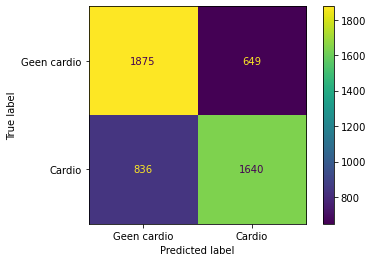

In [73]:
plot_confusion_matrix(clf_svm,
                     X_test_scaled,
                     y_test,
                     values_format='d',
                     display_labels=['Geen cardio', 'Cardio'])

In de confusion matrix zien we dat 70,37% (171) van de mensen die een cardiovasculaire ziekte goed worden geclassificeerd door dit model. Ongeveer 30% (72) van de mensen met een cardiovasculaire ziekte wordt niet herkend. Dit zou betekenen dat 3 op de 10 mensen volgens dit model onterecht 'geen risico' lopen.

# Optimize parameters with cross validation and GridSearchCV()

Om een support vector machine te optimaliseren wordt er gefocust op het vinden van de best mogelijke waarde voor gamma en daarnaast de regularization parameter, C.

Omdat we 2 parameters hebben gebruiken we GridSearchCV(). We speciferen een aantal mogelijke combinaties en GridSearchCV() test al deze mogelijkheden.

In [74]:
param_grid = [
    {'C': [0.5, 1, 10, 100], # C moet groter zijn dan 0
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']},
]

# Ik gebruik C=1 en gamme=scale omdat dit default values zijn.

optimal_params = GridSearchCV(
                    SVC(),
                    param_grid,
                    cv=5,
                    scoring='accuracy', #accuracy is default er zijn nog andere mogelijkheden maar deze verbeteren dit model nauwelijks in ons geval.
                    verbose=0) 

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

KeyboardInterrupt: 

Na cross validation te hebben gedaan zien we dat de ideale value voor C 100 is en voor gamma 0.001

# Building, evaluating, drawing and interpreting the final support vector machine

We gaan nu met de waardes die uit de cross validation kwamen een support vector machine bouwen.

In [75]:
clf_svm = SVC(random_state=42, C=100, gamma=0.001) 
clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.001, random_state=42)

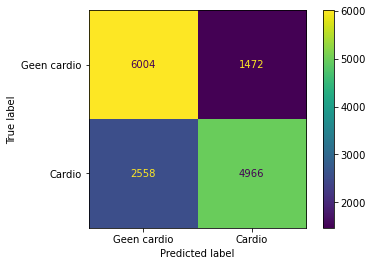

In [76]:
plot_confusion_matrix(clf_svm,
                     X_train_scaled,
                     y_train,
                     values_format='d',
                     display_labels=['Geen cardio', 'Cardio'])

Het optimaliseren heeft in ons geval niet veel geholpen. Het model kan erg goed mensen die geen cardiovasculaire ziekte hebben goed classificeren (85%), maar dit is niet onze target. Wij willen juist een model dat zo min mogelijk mensen met cardiovasculaire ziekte classificeerd als 'geen cardio'.

Als je de parameters iets tweaked kun je wel op een lager percentage komen linksonder, maar dat gaat wel ten koste van de mensen zonder cardio die correct worden geclassificeerd. Dit moeten we overleggen met onze opdrachtgever.

In [48]:
len(df_downsample.columns)

13

We willen nu de support vector machine visualiseren. We zien dat er 13 kolommen zijn en dat zou betekenen dat je een 13 dimensionaal model moet maken. We gebruiken PCA (Principal Component Analysis) om de 13 features te combineren in 2. 

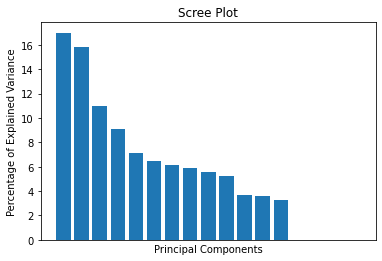

In [55]:
pca = PCA() # by default, PCA() centers the data, but does not scale it.
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x', # changes apply to x axis
    which='both', # both major and minor ticks are affected
    bottom=False, # ticks along the bottom edge are off
    top=False, # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [56]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:,1]

#pc1 contains the x-axis coordinates of the data after PCA
#pc2 contains the y-axis coordinates of hte data after PCA

# Now center and scale the PCs
pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

# Now we optimize the SVM fit to the x and y-axis coordinates of the data after PCA dimension reduction
param_grid = [
    {'C': [1, 10, 100, 1000],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']}
]

optimal_params = GridSearchCV(
        SVC(),
        param_grid,
        cv=5,
        scoring='accuracy',
        verbose=0)

optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


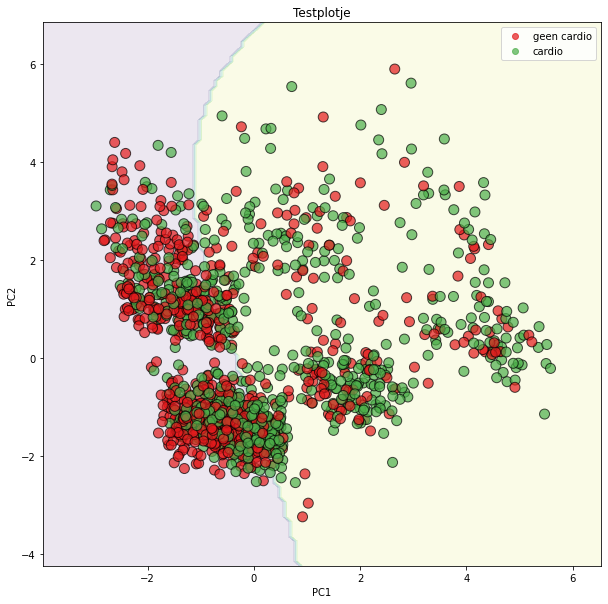

In [61]:
clf_svm = SVC(random_state=42, C=1000, gamma=0.01) 
clf_svm.fit(pca_train_scaled, y_train)

# Transform the test dataset with the PCA 
X_test_pca = pca.transform(X_train_scaled)
#X_test_pca = pca.transform(X_test_scaled)
test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:,1]

#Now create a matrix of points that we can use to show the decision regions
#The matrix will be a little bit larger than the transformed PCA points so 
#that we can plot all of the PCA points on it without them being on the edge.

x_min = test_pc1_coords.min() - 1
x_max = test_pc1_coords.max() + 1

y_min = test_pc2_coords.min() - 1
y_max = test_pc2_coords.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                    np.arange(start=y_min, stop=y_max, step=0.1))

Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))

Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))

ax.contourf(xx, yy, Z, alpha=0.1)

cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])

scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_train,
                    cmap=cmap,
                    s=100,
                    edgecolors='k',
                    alpha=0.7)

legend = ax.legend(scatter.legend_elements()[0],
                  scatter.legend_elements()[1],
                  loc='upper right')
legend.get_texts()[0].set_text('geen cardio')
legend.get_texts()[1].set_text('cardio')

ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Testplotje')

plt.show()

